# EMD algorithm - Experiments with lateral acceleration in one trip

## Maria Inês Silva
## 02/02/2019

***

## Data and library imports

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import extendedMD.emd as emd
from extendedMD.viz import create_motif_table, plot_k_motifs
from extendedMD.pruning import prune_motifs_with_mdl

# local code
import sys
import os
sys.path.insert(0, os.path.abspath('../scripts'))
import dtw_clustering as clust

In [2]:
cwd = os.getcwd()
data_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'data-uah'))
output_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'data-motifs'))
exp = 1

In [3]:
trip_df = pd.read_pickle(os.path.join(data_folder, 'trip_df.pkl'))
ts = trip_df['ay'].values
events_ts = trip_df['event_type'].values

In [4]:
trip_df

,timestamp,ax,ay,az,roll,pitch,yaw,speed,event_type,event_level,event,user_id,trip_id,trip_label,road
0,13.0,0.016,-0.034,0.013,-1.588,0.002,-0.018,67.044823,0.0,0.0,00,D6,20151221120051,2,motorway
1,13.1,-0.022,-0.005,0.003,-1.592,0.002,-0.017,66.556897,0.0,0.0,00,D6,20151221120051,2,motorway
2,13.2,-0.017,0.006,0.010,-1.597,0.004,-0.017,66.184801,0.0,0.0,00,D6,20151221120051,2,motorway
3,13.3,-0.023,0.004,-0.012,-1.593,-0.001,-0.016,65.970512,0.0,0.0,00,D6,20151221120051,2,motorway
4,13.4,-0.002,-0.012,-0.027,-1.593,-0.001,-0.016,65.938475,0.0,0.0,00,D6,20151221120051,2,motorway
5,13.5,0.056,0.004,-0.011,-1.597,-0.009,-0.014,66.094740,0.0,0.0,00,D6,20151221120051,2,motorway
6,13.6,0.006,0.019,-0.015,-1.597,-0.008,-0.014,66.427804,0.0,0.0,00,D6,20151221120051,2,motorway
7,13.7,0.027,-0.001,0.006,-1.597,-0.010,-0.013,66.910989,0.0,0.0,00,D6,20151221120051,2,motorway
8,13.8,-0.033,-0.010,-0.023,-1.594,-0.012,-0.013,67.505976,0.0,0.0,00,D6,20151221120051,2,motorway
9,13.9,-0.027,-0.065,-0.039,-1.596,-0.012,-0.014,68.167111,0.0,0.0,00,D6,20151221120051,2,motorway


## Experiment 1

In [4]:
R = 0.2
win_size = 15
paa_size = 3
alphabet_size = 5
adaptive_break_points = True

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [5]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted
ExtendedMD algorithm run in 11.5 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
38,[bdc],1,229,48322.28,0.10
28,[cbd],1,229,48502.38,0.11
54,[bcd],1,205,49278.45,0.10
40,[dbc],1,213,49398.98,0.11
19,[cdb],1,209,49422.79,0.09
3,[dcb],1,207,49764.21,0.10
35,[ccc],1,195,50814.52,0.10
33,[bbe],1,167,51274.92,0.11
14,[add],1,160,51796.93,0.10
21,[dda],1,154,51887.46,0.12


In [6]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.07 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[bdc],1,229,48322.28,0.10
1,"[dda, eda, eca, ebb, dbc]",5,2,97972.26,0.10
2,"[dda, eda, eca, eba, ebb, ecb, dcb]",7,2,100556.57,0.06
3,"[ace, ade, add, ade]",4,2,105539.32,0.09


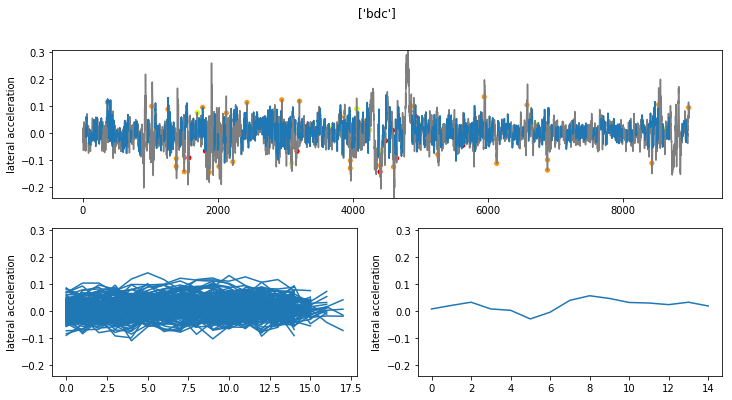

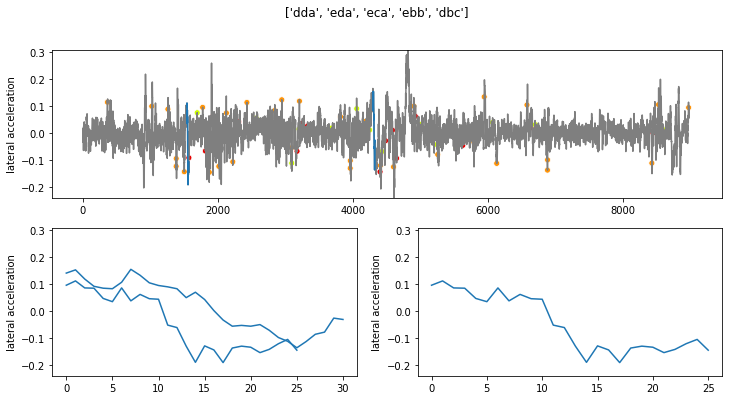

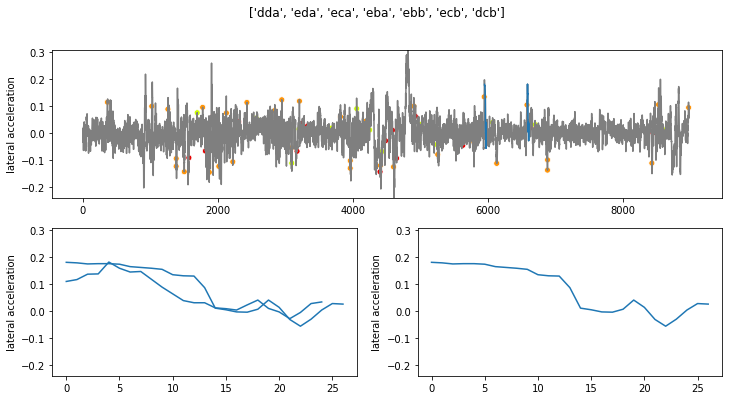

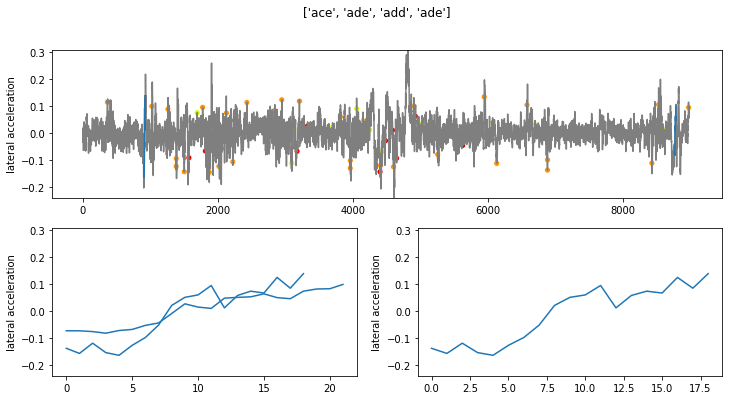

In [7]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

In [8]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)
np.save(os.path.join(output_folder, dist_file_name), center_dist_mat)

Distance matrix computed in 32.9 minutes


## Experiment 2

In [9]:
R = 0.2
win_size = 20
paa_size = 4
alphabet_size = 5
adaptive_break_points = True

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [10]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted
ExtendedMD algorithm run in 8.07 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
186,[bbdd],1,98,59595.93,0.11
32,[acdd],1,94,60496.97,0.11
48,[ddca],1,82,62102.85,0.10
113,[cdcb],1,83,62161.45,0.10
49,[bddb],1,75,62743.99,0.12
148,[ecbb],1,80,62769.58,0.14
123,[bbce],1,76,63096.47,0.12
196,[cbcd],1,76,63468.81,0.11
147,[dbbd],1,74,63648.69,0.13
16,[ddbb],1,78,63764.57,0.10


In [11]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.12 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[bbdd],1,98,59595.93,0.11
1,"[ddca, edca, edba, ecba]",4,3,99006.38,0.08
2,"[cbbe, bbbe, bbce, abce]",4,2,100472.19,0.09
3,"[adeb, bddb, ceca]",3,2,102612.02,0.10


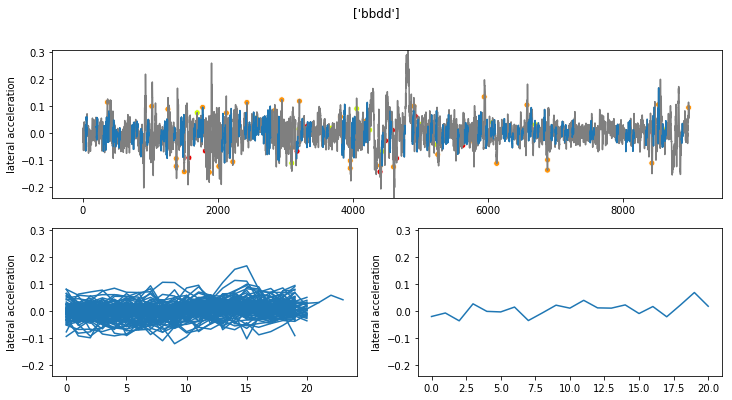

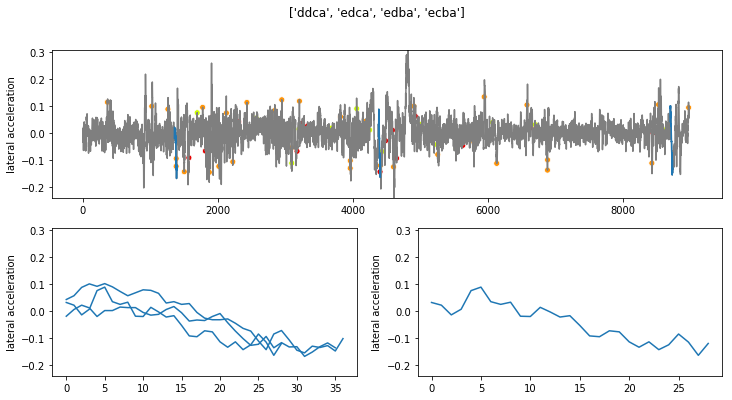

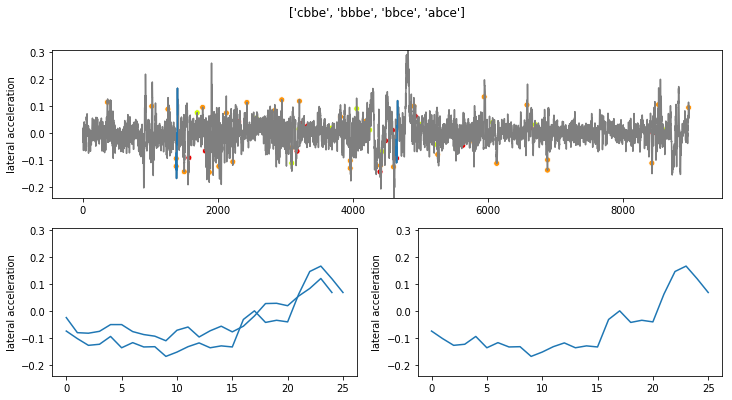

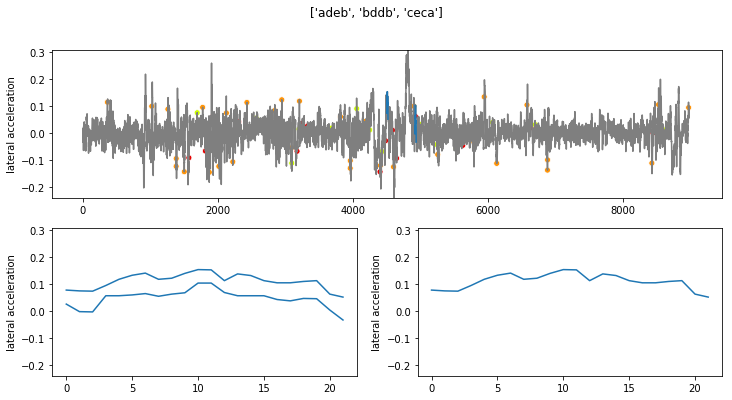

In [12]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

In [13]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)
np.save(os.path.join(output_folder, dist_file_name), center_dist_mat)

Distance matrix computed in 30.5 minutes


## Experiment 3

In [14]:
R = 0.2
win_size = 20
paa_size = 2
alphabet_size = 5
adaptive_break_points = True

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [15]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted
Motif candidates of size 12 successfully extracted
Motif candidates of size 13 successfully extracted
Motif candidates of size 14 successfully extracted
Motif candidates of size 15 successfully extracted
Motif candidates of size 16 successfully extracted
Motif candidates of size 17 successfully extracted
Motif candidates of size 18 successfully extracted
Motif candidates of size 19 successfully extracted
Motif candidates of size 20 successfully

,pattern,pattern_len,n_members,mdl_cost,mean_dist
3,[bd],1,179,27262.34,0.12
1,[cc],1,205,28090.18,0.11
7,"[bd, cc]",2,145,28358.73,0.15
0,[db],1,171,28483.80,0.14
10,"[cc, bd]",2,147,28552.46,0.12
6,"[cc, db]",2,145,28841.25,0.13
12,"[db, cc]",2,150,28895.95,0.14
24,"[bd, cc, db]",3,109,31040.24,0.17
20,"[cc, db, cc]",3,111,31351.22,0.15
25,"[cc, bd, cc]",3,111,31406.55,0.12


In [16]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.53 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[bd],1,179,27262.34,0.12
1,"[ae, bd, cc, db, ea, db, cc, bd, ae, bd, cc, d...",15,2,79791.79,0.10
2,"[db, cc, db, cc, bd, ae, bd, cc, db, ea, db, c...",17,2,80872.55,0.10
3,"[ea, db, ea]",3,3,81370.20,0.08


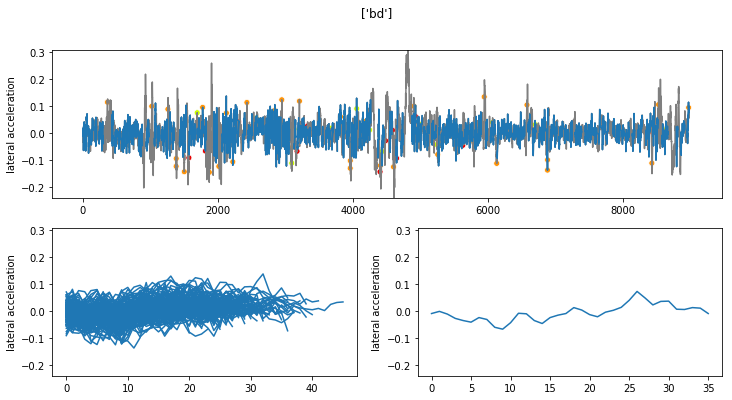

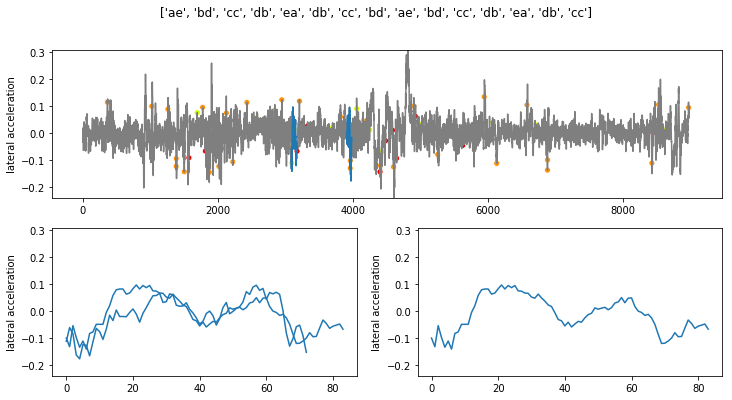

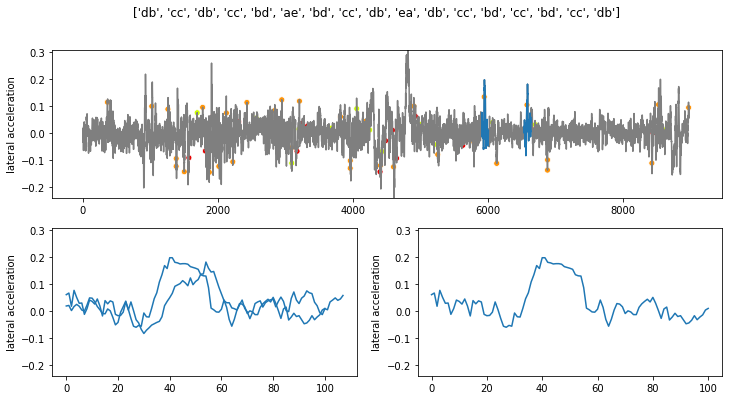

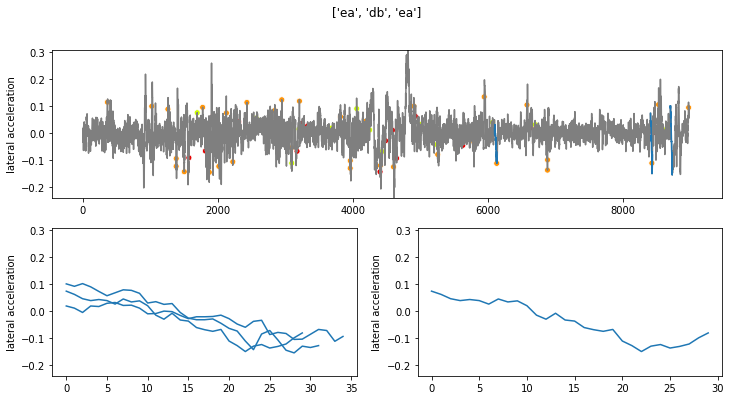

In [17]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

In [18]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)
np.save(os.path.join(output_folder, dist_file_name), center_dist_mat)

Distance matrix computed in 295.4 minutes


## Experiment 4

In [38]:
R = 0.1
win_size = 15
paa_size = 3
alphabet_size = 7
adaptive_break_points = False

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [39]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted
Motif candidates of size 12 successfully extracted
Motif candidates of size 13 successfully extracted
Motif candidates of size 14 successfully extracted
ExtendedMD algorithm run in 7.66 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
33,[ddd],1,81,58324.44,0.06
174,[cdd],1,87,58604.28,0.06
36,[ccd],1,78,58691.39,0.07
214,[dcc],1,78,58772.31,0.07
40,[ddc],1,76,59135.00,0.06
6,[ded],1,72,59282.39,0.05
145,[ccc],1,71,59776.47,0.06
190,[dcd],1,71,59862.95,0.06
1,[edc],1,64,60131.87,0.06
17,[edd],1,67,60238.05,0.06


In [40]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.13 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[ddd],1,81,58324.44,0.06
1,[ggg],1,14,78552.14,0.07
2,[baa],1,8,86043.30,0.07
3,[adg],1,5,88140.18,0.07
4,[aba],1,5,93484.24,0.06
5,"[gfb, geb]",2,4,94386.45,0.06
6,"[adg, beg, bfg, bgg, cgg, dgg, egg, fgg, ggg, ...",11,2,97864.07,0.05
7,"[dgg, egg, fgg]",3,2,99459.61,0.05


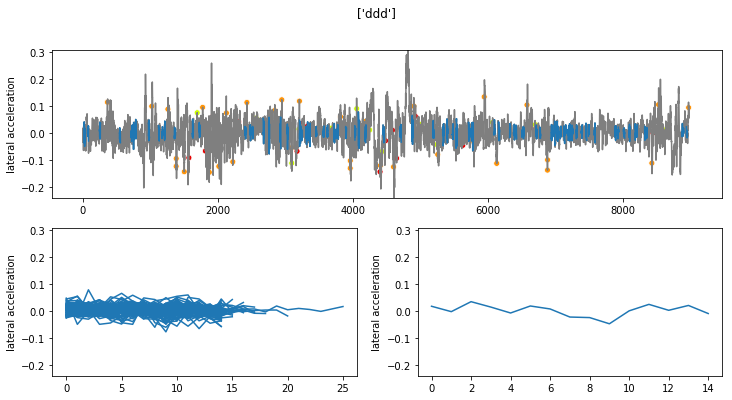

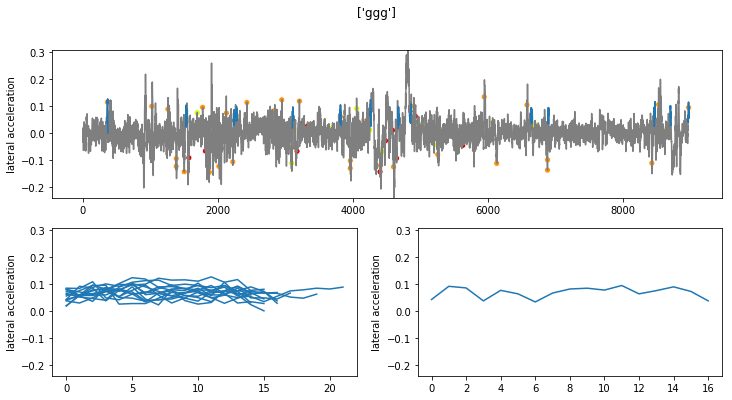

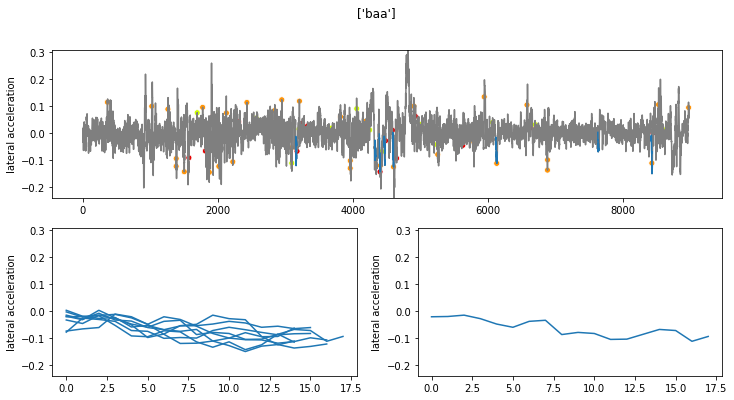

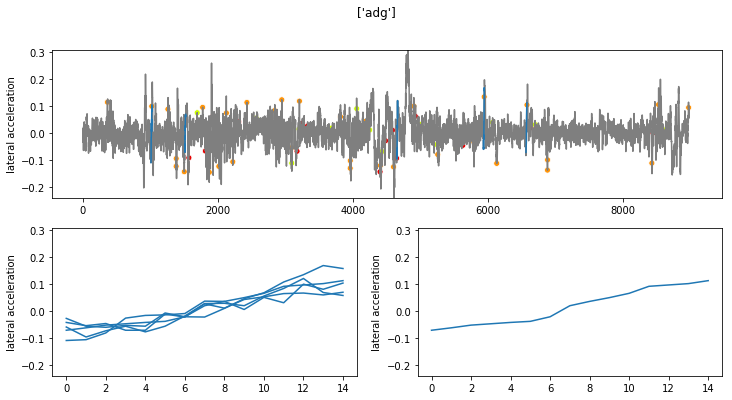

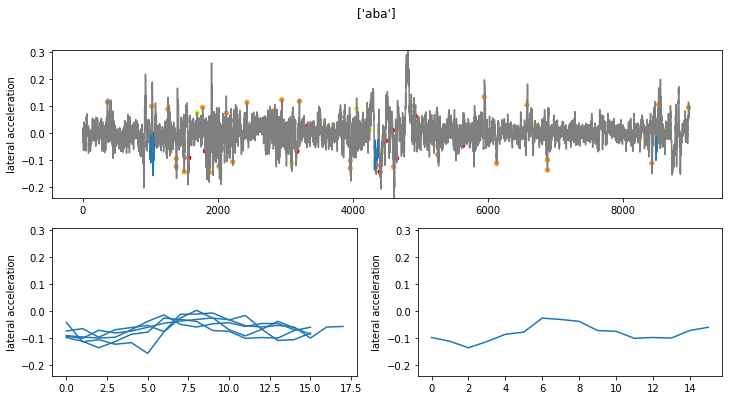

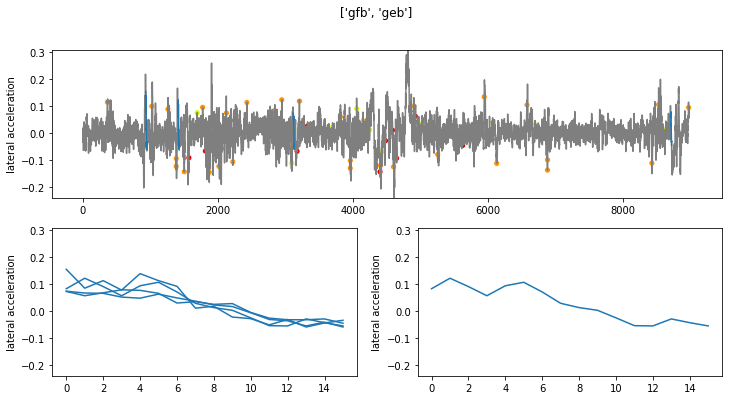

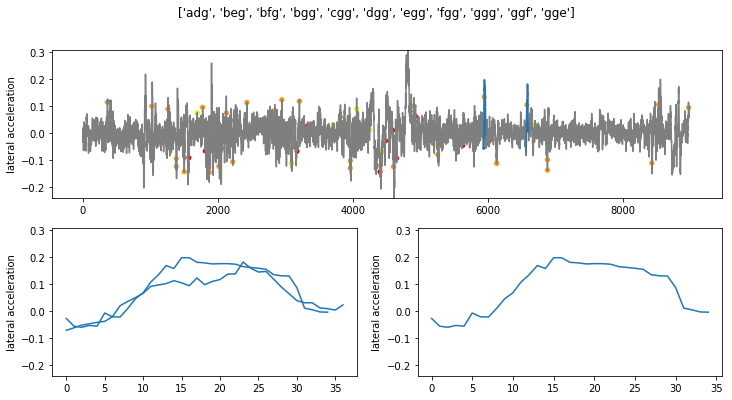

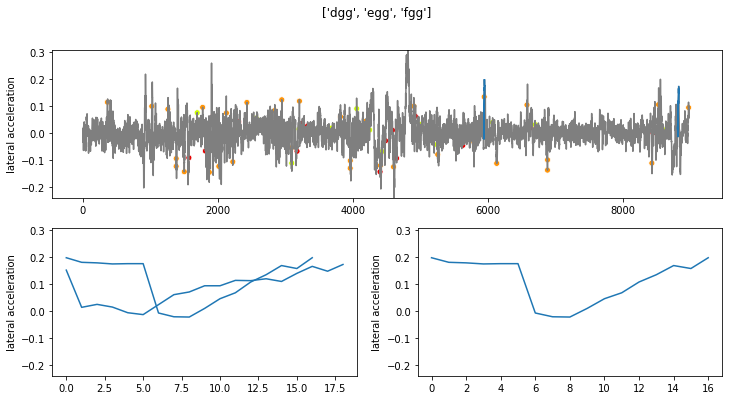

In [41]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

In [42]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)
np.save(os.path.join(output_folder, dist_file_name), center_dist_mat)

Distance matrix computed in 21.8 minutes


## Experiment 5

In [24]:
R = 0.2
win_size = 20
paa_size = 4
alphabet_size = 7
adaptive_break_points = False

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [25]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted
ExtendedMD algorithm run in 6.19 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
294,[ddde],1,37,68921.44,0.06
242,[cccd],1,38,69530.09,0.07
604,[dccc],1,44,69661.18,0.07
435,[dded],1,38,69905.21,0.06
385,[ccdd],1,39,69914.61,0.06
549,[ccdc],1,27,71059.84,0.06
142,[deed],1,32,71073.51,0.07
614,[dddd],1,35,71173.09,0.06
346,[ddcc],1,33,71356.41,0.06
19,[dedd],1,33,71368.86,0.06


In [26]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.14 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[ddde],1,37,68921.44,0.06
1,[gggg],1,11,82006.47,0.13
2,[caaa],1,11,85317.76,0.11
3,"[aafg, abgg, adgg]",3,2,100213.59,0.10


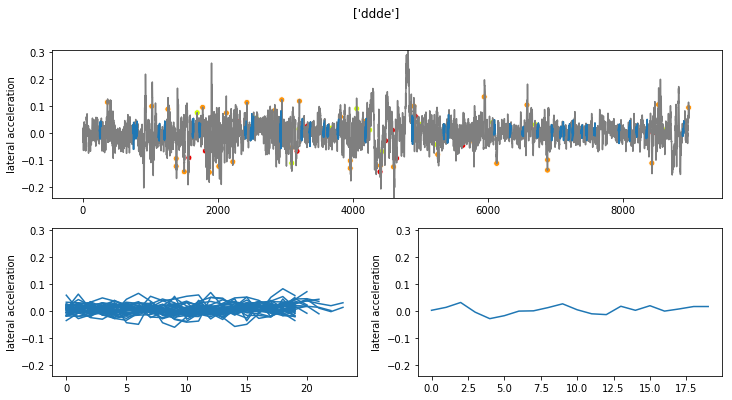

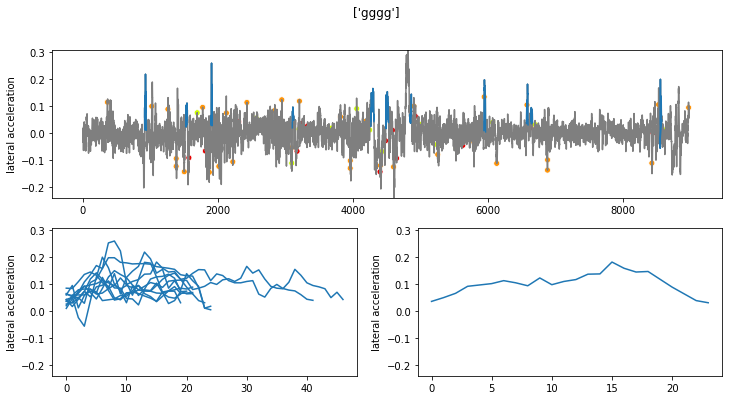

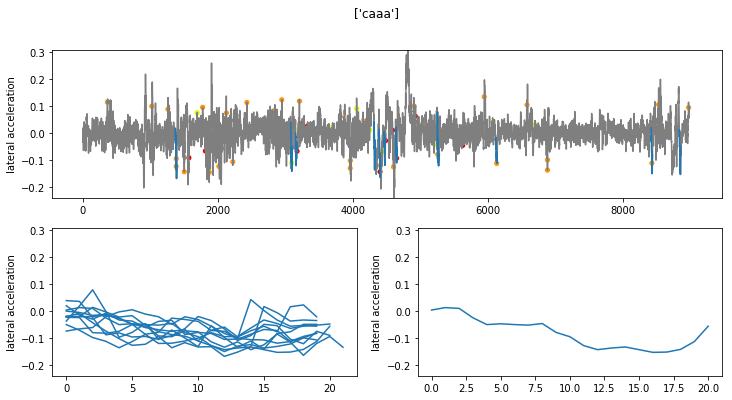

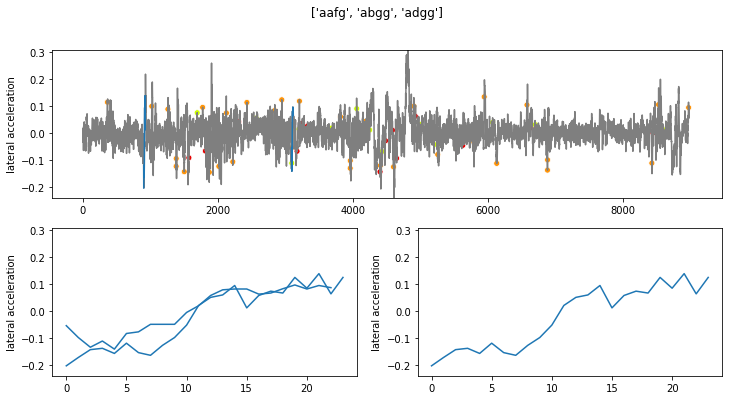

In [27]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

In [28]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)
np.save(os.path.join(output_folder, dist_file_name), center_dist_mat)

Distance matrix computed in 30.2 minutes


## Experiment 6

In [29]:
R = 0.2
win_size = 20
paa_size = 2
alphabet_size = 7
adaptive_break_points = False

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [30]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted
Motif candidates of size 12 successfully extracted
Motif candidates of size 13 successfully extracted
Motif candidates of size 14 successfully extracted
Motif candidates of size 15 successfully extracted
Motif candidates of size 16 successfully extracted
Motif candidates of size 17 successfully extracted
Motif candidates of size 18 successfully extracted
Motif candidates of size 19 successfully extracted
Motif candidates of size 20 successfully

,pattern,pattern_len,n_members,mdl_cost,mean_dist
47,[dd],1,119,41064.51,0.09
35,[cd],1,114,41482.01,0.14
7,[dc],1,111,41973.72,0.09
20,[ed],1,107,42274.54,0.12
3,[de],1,99,42963.68,0.09
21,[ec],1,88,44419.90,0.10
14,[cc],1,93,44577.34,0.09
34,[ce],1,80,46058.46,0.10
38,[ee],1,80,46171.17,0.09
192,"[cd, dd]",2,58,48155.89,0.14


In [31]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.23 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[dd],1,119,41064.51,0.09
1,"[fg, gg]",2,15,64930.34,0.15
2,"[ab, ac, ad, ae, af, ag, bg]",7,2,87129.37,0.09


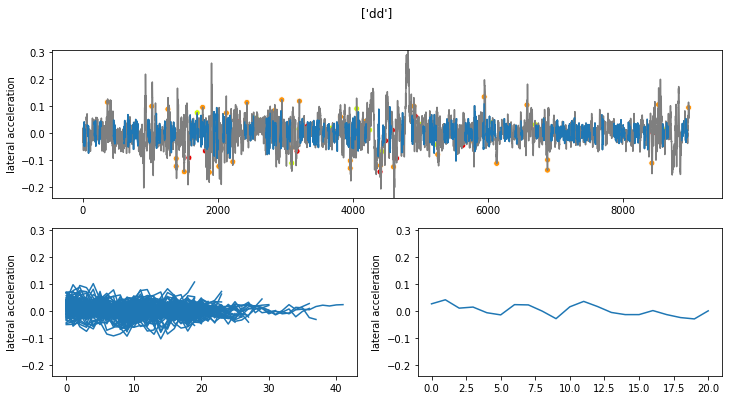

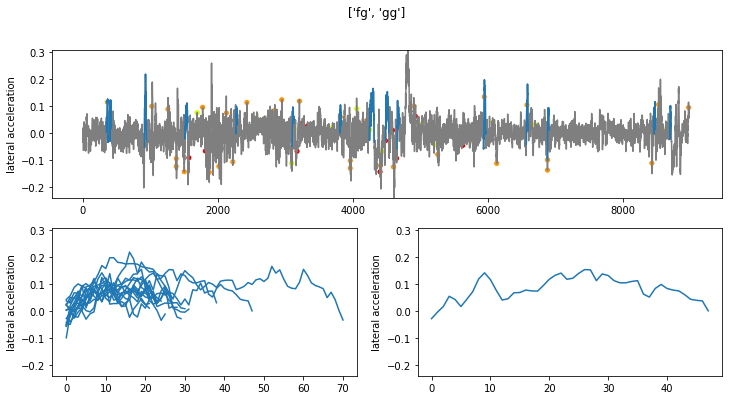

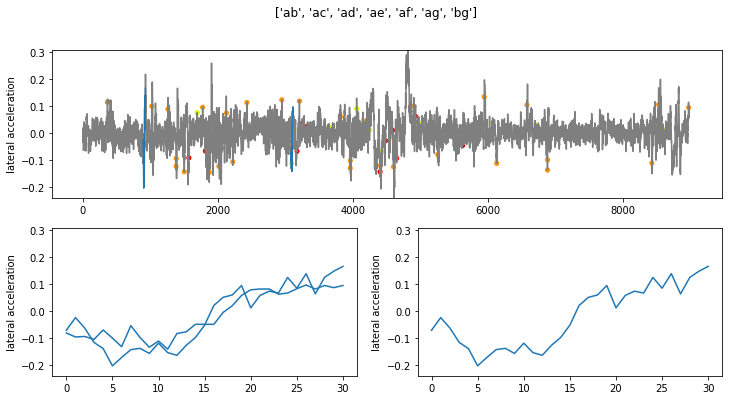

In [32]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

In [33]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)
np.save(os.path.join(output_folder, dist_file_name), center_dist_mat)

Distance matrix computed in 67.5 minutes


## Experiment 7

In [44]:
R = 0.1
win_size = 10
paa_size = 2
alphabet_size = 5
adaptive_break_points = False

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [45]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted
Motif candidates of size 12 successfully extracted
Motif candidates of size 13 successfully extracted
Motif candidates of size 14 successfully extracted
Motif candidates of size 15 successfully extracted
Motif candidates of size 16 successfully extracted
Motif candidates of size 17 successfully extracted
ExtendedMD algorithm run in 8.98 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
5,[cc],1,233,37628.27,0.06
15,[bc],1,209,38773.75,0.06
16,[cd],1,194,38853.64,0.06
2,[dc],1,184,39775.43,0.06
3,[cb],1,192,39961.75,0.06
11,[bb],1,152,42013.75,0.06
23,[dd],1,131,43174.12,0.06
127,"[cc, cd]",2,98,44801.18,0.06
41,"[bc, cc]",2,101,45309.06,0.06
17,[db],1,101,45409.90,0.06


In [46]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.12 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[cc],1,233,37628.27,0.06
1,"[ee, ed]",2,29,60588.81,0.08
2,"[ca, ba, aa, ab, ac, ad]",6,4,79521.46,0.07
3,"[db, ca, ba]",3,4,84043.58,0.05
4,"[ec, eb, ea, da, ca, ba]",6,2,86534.27,0.05
5,"[ae, ce]",2,2,89274.96,0.05
6,"[ac, bb, cb]",3,2,93028.10,0.04


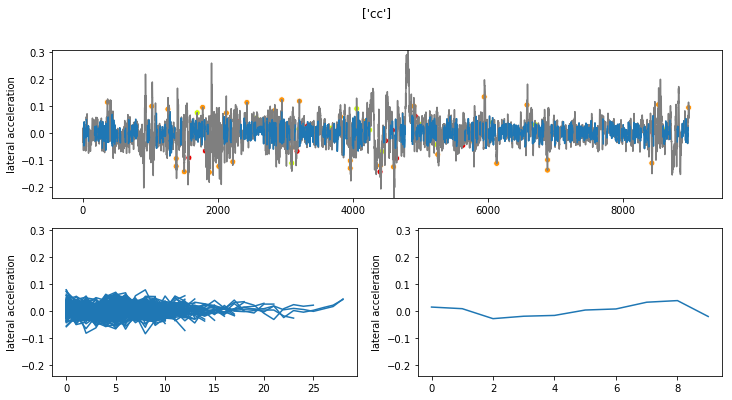

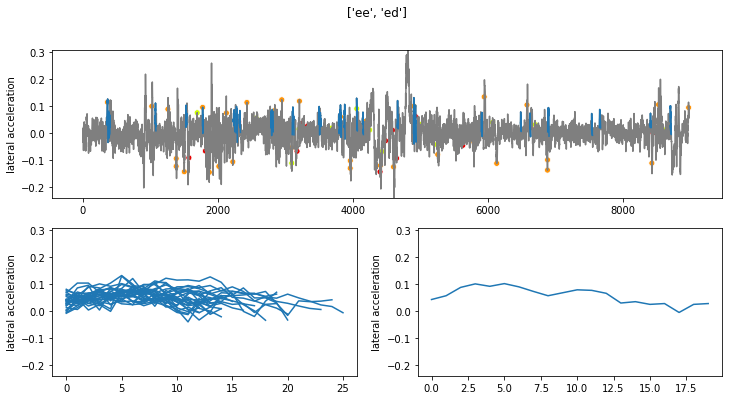

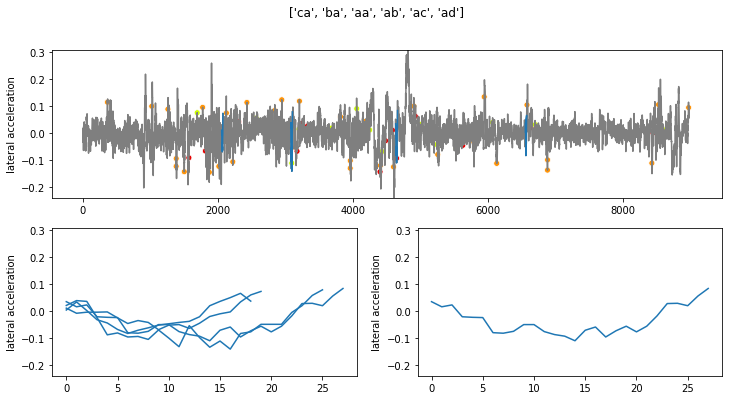

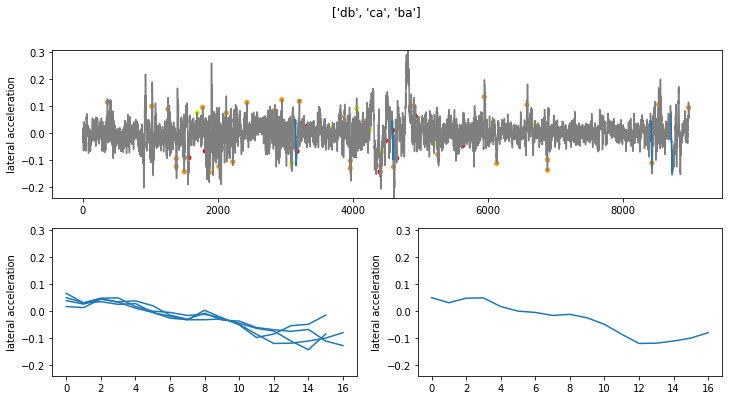

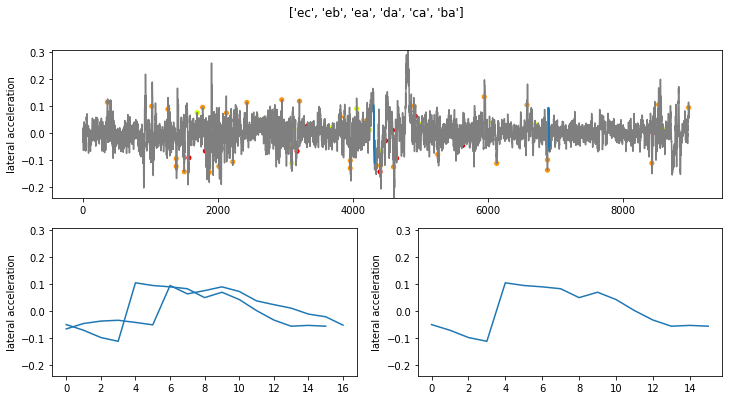

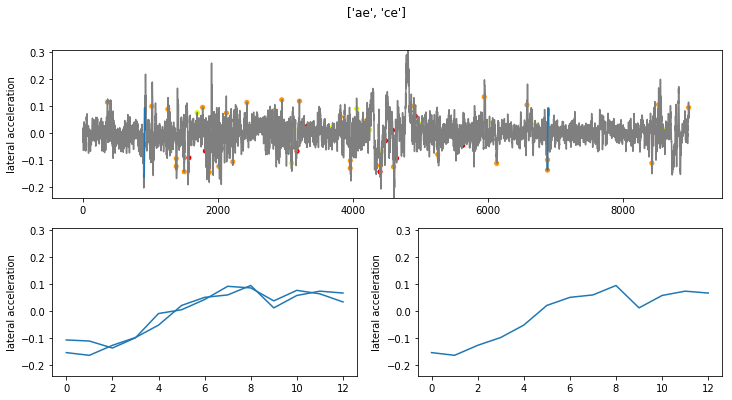

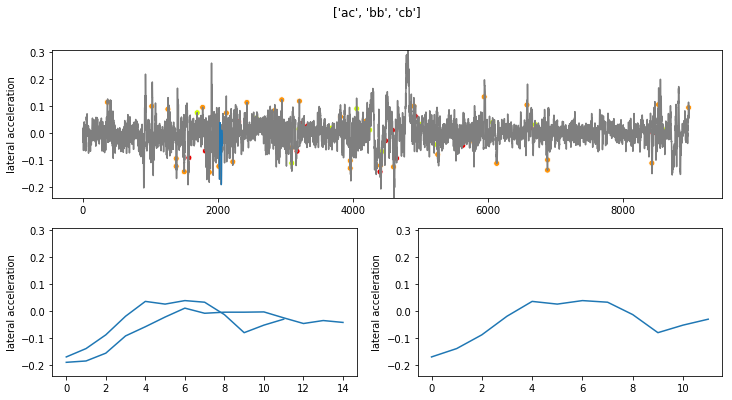

In [47]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

## Experiment 8

In [48]:
R = 0.1
win_size = 10
paa_size = 4
alphabet_size = 5
adaptive_break_points = False

motif_file_name = 'motif_lat_acc_trip_exp' + str(exp) + '.p'
dist_file_name = 'dist_lat_acc_trip_exp' + str(exp) + '.npy'
exp += 1

In [49]:
start_time = time.time()
motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
pickle.dump(motif_dic_list, open(os.path.join(output_folder, motif_file_name), "wb"))
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

motif_df = create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
ExtendedMD algorithm run in 8.25 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
328,[bccc],1,93,59719.07,0.04
233,[cbcc],1,97,60062.20,0.04
260,[cccc],1,100,60292.59,0.05
172,[ccdd],1,89,60338.49,0.04
108,[cccd],1,98,60568.14,0.04
251,[ccdc],1,88,60610.27,0.04
300,[bbcc],1,86,61232.01,0.04
286,[ccbb],1,80,61427.49,0.04
87,[cbbc],1,82,61569.67,0.04
29,[ccbc],1,89,61571.24,0.04


In [50]:
start_time = time.time()
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)
pruned_motif_df = create_motif_table(pruned_motif_dic_list)
print("Prunning algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))
pruned_motif_df

Prunning algorithm run in 0.1 minutes


,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[bccc],1,93,59719.07,0.04
1,[deee],1,38,70656.98,0.08
2,"[baaa, aaaa, aaab]",3,10,82901.05,0.08
3,"[eedb, eecb]",2,5,91164.50,0.05
4,[adee],1,4,92673.96,0.06
5,[beee],1,2,97495.32,0.04
6,"[aaba, aaaa, abaa]",3,2,101041.40,0.02


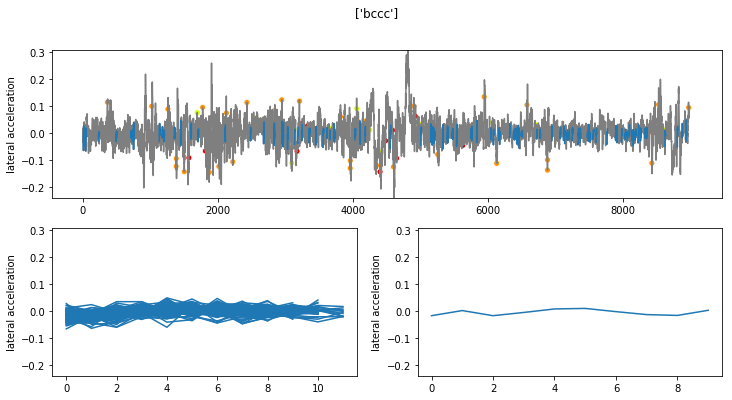

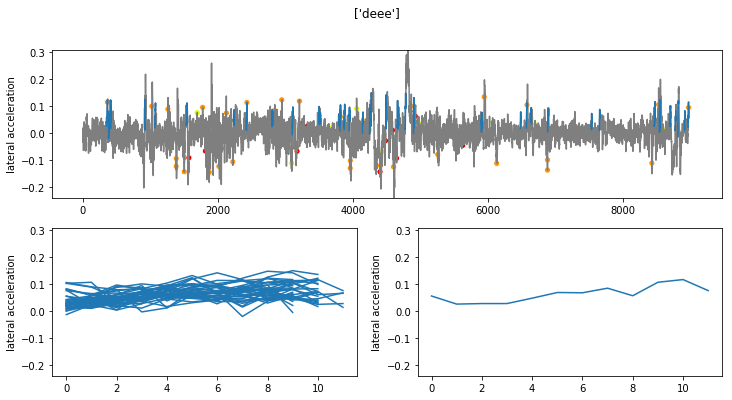

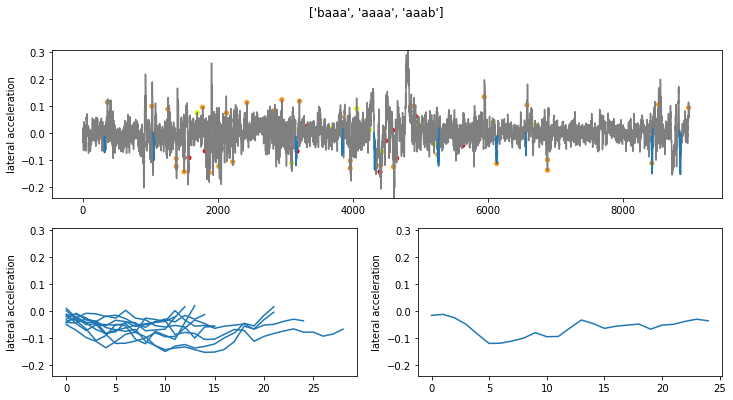

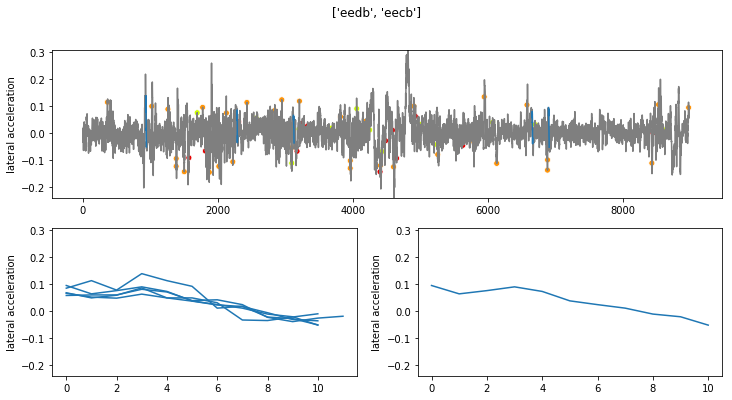

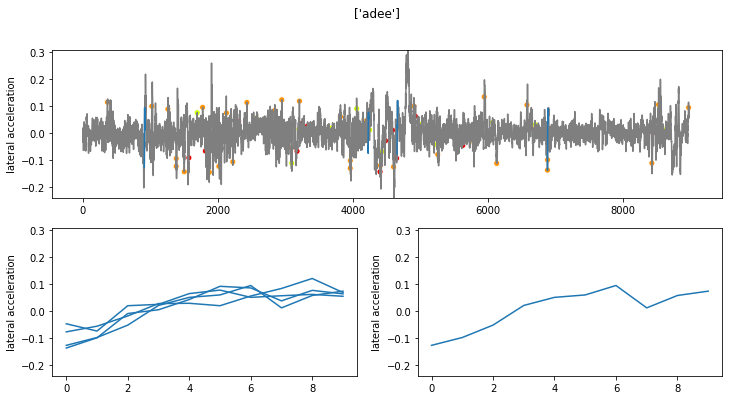

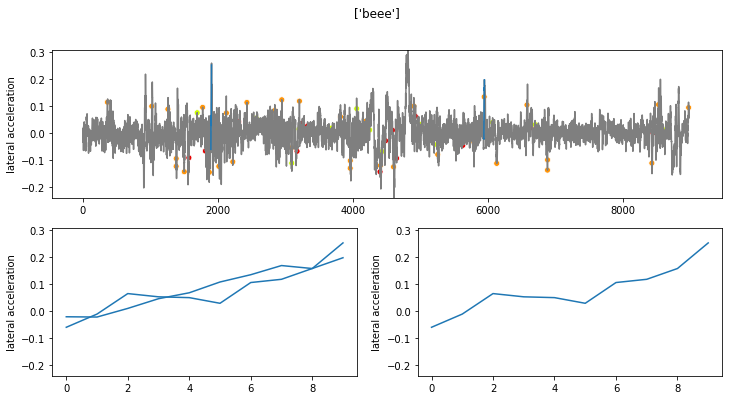

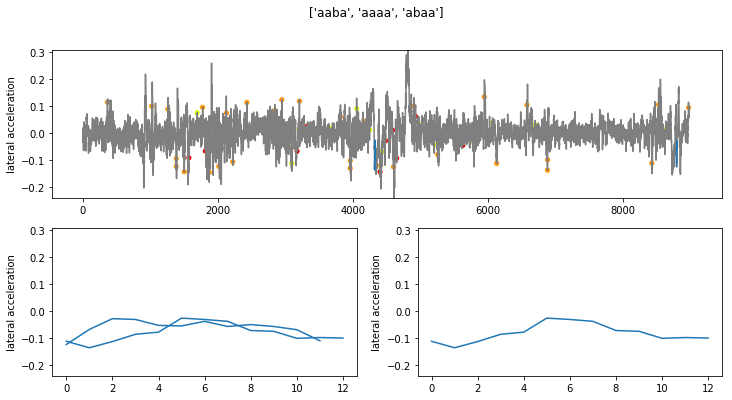

In [51]:
plot_k_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list, 'lateral acceleration')

In [52]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)
np.save(os.path.join(output_folder, dist_file_name), center_dist_mat)

Distance matrix computed in 17.5 minutes
